In [1]:
import json
import gzip
import pandas as pd

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13132\840360880.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Importing metadata zip file and converting it to dataframe

def getDF(path):
  # Unzip the file, load in each line as an object
  g = gzip.open(path, 'rb')
  g = [json.loads(l) for l in g]

  # Map to a dictionary, then load in as a dataframe
  dict_df = {i: d for (i, d) in enumerate(g)}
  return pd.DataFrame.from_dict(dict_df, orient='index')

df = getDF('All_Beauty.json.gz')

In [3]:
# Find any reviews that are empty or null and remove them (there are non)

df_empty_reviews_index = (df["reviewText"] == "" )|( df["reviewText"].isnull())
print("There are no empty reviews")

df[df_empty_reviews_index]

df = df.drop(df[ ( (df["reviewText"] == "" ) | ( df["reviewText"].isnull()) ) ].index)

There are no empty reviews


In [4]:
# Selecting only the colums that are required for analysis

colums_reviewtext_asin = ["reviewText", "asin", "reviewerID"]
df = df[colums_reviewtext_asin]

df.describe()


,reviewText,asin,reviewerID
count,370946,370946,370946
unique,319643,32571,323687
top,Good,B000FOI48G,A2GJX2KCUSR0EI
freq,802,8671,27


In [5]:
# Remove all duplicates as they affect classifiers learning 

# Remove duplicate reviews
df[df.duplicated("reviewText")]
df = df.drop_duplicates("reviewText", keep="last")
df.describe() 

# Matches number of unique reviews now

,reviewText,asin,reviewerID
count,319643,319643,319643
unique,319643,31438,299718
top,My husband wanted to reading about the Negro ...,B000FOI48G,A2GJX2KCUSR0EI
freq,1,8268,25


In [6]:
# Identify range of reviews in after duplicates removal

df_reviews_without_empty = df["reviewText"].apply(lambda x: len(x.split()))

df_reviews_without_empty.describe([0.1,0.15,0.20,0.25,0.30,0.75,0.85,0.90,0.92,0.95,0.97,0.98,0.99])

# under or equal to 95% (140 words )because after it increases substantially in length only for a small portion of reviews
# However choose 97% to help the classifier learn from larger samples
# under or equal to 20% (11 words) because uder that too litle words for classifier to learn especially after it is cleaned 

count    319643.000000
mean         42.042973
std          59.966297
min           1.000000
10%           5.000000
15%           7.000000
20%           9.000000
25%          11.000000
30%          13.000000
50%          24.000000
75%          49.000000
85%          73.000000
90%          95.000000
92%         109.000000
95%         140.000000
97%         181.000000
98%         216.000000
99%         287.000000
max        2443.000000
Name: reviewText, dtype: float64

In [7]:
# Remove reviews with more or less than xx pre-cleaned words

# Split at any white space 
df["num_words_reviews"] = df["reviewText"].apply(lambda x: len(x.split()))

# Check if under or equal to 80% words fulfils withs condition and set it
df = df[(df["num_words_reviews"] <= 181) & (df["num_words_reviews"] >= 11)]

df["reviewText"].describe()

# Reviews consisting of less than 8 word might not be usefull for classification as clasifier won't have enough information to learn from them
# Especially after cleaning, only a few words will be left

count                                                230961
unique                                               230961
top       My  husband wanted to reading about the Negro ...
freq                                                      1
Name: reviewText, dtype: object

In [8]:
# Identify range of reviews in after duplicates removal

df_reviews_without_empty = df["reviewText"].apply(lambda x: len(x.split()))

df_reviews_without_empty.describe([0.03,0.1,0.75,0.85,0.90,0.95])

count    230961.000000
mean         44.232533
std          34.441983
min          11.000000
3%           11.000000
10%          14.000000
50%          32.000000
75%          57.000000
85%          77.000000
90%          94.000000
95%         121.000000
max         181.000000
Name: reviewText, dtype: float64

In [9]:
# Regrex for character removal
import re

# Spacy for spell check
import spacy
import contextualSpellCheck
nlp = spacy.load("en_core_web_sm")
contextualSpellCheck.add_to_pipe(nlp)

# NLTK for tokenisation and lemmatization
import nltk

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

# Spacy stop word creation
stopping_words = spacy.lang.en.stop_words.STOP_WORDS
stopping_words_new = stopping_words


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
stopping_words_to_remove = ['without' , 'not', 'less', 'noting', 'none','no']
for word in list(stopping_words_new):
    if word in stopping_words_to_remove:
        stopping_words_new.remove(word)
print(stopping_words_new)

{'mostly', 'few', '’ve', 'hereby', 'there', 'can', 'yours', 'during', 'thus', '’d', 'give', 'nor', 'beforehand', 'whoever', 'has', 'his', 'formerly', 'doing', 'further', 'for', 'amongst', 'how', 'above', 'twelve', 'whither', 'down', 'show', 'amount', 'anywhere', 'these', 'us', 'whenever', 'we', 'becoming', 'such', 'several', "'ll", 'seeming', 'least', 'too', 'always', 'regarding', 'somewhere', "'ve", 'with', 'sometimes', 'same', 'its', 'to', 'sometime', 'why', 'call', 'side', 'nine', 'unless', 'against', 'their', 'and', 'per', 'bottom', 'various', 'at', 'this', 'ten', 'eleven', 'have', 'serious', 'move', 'ours', 'while', 'hereupon', 'n’t', 'fifty', '’ll', 'somehow', 'third', 'some', 'within', 'on', 'wherein', 'perhaps', 'itself', 'keep', 'therein', 'own', 'onto', '‘d', 'seemed', 'what', 'therefore', 'say', "'m", 'still', 'done', 'other', 'just', 'that', 'due', 'herself', 'before', 'next', '’s', 'go', 'either', 'every', 'really', 'become', 'neither', 'quite', 'because', 'even', 'whateve

In [11]:
# Preprocessing of reviews

def preprocessing(raw_string):
    # Remove html tags and anything inside them 
    no_html = re.sub(r'<[^>]*>','', raw_string)
    #print("after removing html", no_html)

    # Make everything lowercase
    lowercase_column = no_html.lower()
    #print("lowercase", lowercase_column)

    # TODO Might not be a good idea as there are \' inside text which might afect the cleaning 
    # Remove apostrophe to enable spell check to correct words with apostrophe
    #without_apostrophe = re.sub(r'[\']', '', lowercase_column)

    # TODO Need to double check again where best to use this spell check
    # 
    # .pepe for batches of text
    #doc = list(nlp.pipe(without_apostrophe))

    #spell_checked = doc._.outcome_spellCheck

    # Remove all non alphabetic instances that aren't a space and replace them with a space using Regrex
    alphabetic_column = re.sub(r'[^a-z\s]', ' ', lowercase_column)
    #print("removed numerical and punctuation", alphabetic_column)

    # Tokenize string into individual words
    tokens = word_tokenize(alphabetic_column)

    # Remove stopping words using Spacy library
    tokens_without_stopping_words = [token for token in tokens if token not in stopping_words_new]

    # Lemmatize tokens using nltk and join them into sentances
    sentances_without_stop_words = ' '.join([lemmatizer.lemmatize(t) for t in tokens_without_stopping_words])

    return sentances_without_stop_words


In [12]:
df["clean_reviews"] = df["reviewText"].head(240000).apply(preprocessing)

df["clean_reviews"]

df["clean_reviews"].to_csv("out_new.csv")

In [13]:
# Find any reviews that are empty or null and remove them 

df = df.drop(df[ ( (df["clean_reviews"] == "" ) | ( df["clean_reviews"].isnull()) ) ].index)

In [14]:
# Identifying range of reviews in after cleaning
 
df_reviews_without_empty_clean = df["clean_reviews"].apply(lambda x: len(x.split()))

df_reviews_without_empty_clean.describe([0.03,0.1,0.75,0.85,0.90,0.95])

count    230957.000000
mean         20.047814
std          15.363145
min           1.000000
3%            5.000000
10%           7.000000
50%          15.000000
75%          25.000000
85%          35.000000
90%          42.000000
95%          54.000000
max         149.000000
Name: clean_reviews, dtype: float64

In [15]:
from collections import Counter
Counter(" ".join(df["clean_reviews"]).split()).most_common(100)

[('not', 86982),
 ('t', 83469),
 ('product', 81527),
 ('s', 54681),
 ('great', 53193),
 ('like', 52992),
 ('use', 52311),
 ('love', 48486),
 ('hair', 45497),
 ('work', 42505),
 ('skin', 39426),
 ('good', 38278),
 ('time', 30787),
 ('smell', 25842),
 ('no', 25245),
 ('day', 23217),
 ('don', 23194),
 ('color', 22399),
 ('little', 20910),
 ('look', 20723),
 ('ve', 20652),
 ('price', 20289),
 ('year', 20218),
 ('m', 19823),
 ('feel', 19611),
 ('nice', 19067),
 ('brush', 18123),
 ('buy', 17395),
 ('bought', 17182),
 ('long', 16784),
 ('better', 16320),
 ('recommend', 16039),
 ('razor', 16031),
 ('face', 15997),
 ('doesn', 14665),
 ('dry', 14584),
 ('got', 14579),
 ('best', 14012),
 ('easy', 13523),
 ('shave', 13186),
 ('week', 12817),
 ('didn', 12497),
 ('way', 12450),
 ('quality', 12413),
 ('tried', 12400),
 ('clean', 12338),
 ('need', 11986),
 ('scent', 11956),
 ('soap', 11920),
 ('oil', 11270),
 ('find', 10859),
 ('perfect', 10708),
 ('month', 10649),
 ('thing', 10598),
 ('blade', 10548)

In [16]:
###############################################################
#                      Cleaning Keywords                                

# TODO use finalise list of keywords

enviromental = ['biodegradable', 'reduced packaging', 'reduced', 'sustainable', 'plastic-free', 'sustainably sourced', 'compostable', 'renewable', 'renewable energy', 'reusable', 'biodegradable', 'organic', 'refillable', 'refills', 'solid bar', 'recycled', 'cardboard', 'reef safe','reef-friendly', 'oxybenzone free', 'triclosan-free', 'microplastics free', 'microbeads free', 'palm oil free', 'HDPE', 'post-consumer recycled plastic', 'renewable energy', 'recycling scheme', 'sustainably sourced', 'low-impact', 'carbon neutral', 'carbon offsetting', 'eco', 'soil association', 'conservation', 'COSMOS', 'NATRUE', 'RSPO', 'FSC']
social = ['No animal testing', 'cruelty-free', 'vegan', 'plant-based', 'palm oil-free', 'ethical', 'vegan society', 'PETA', 'leaping bunny', 'fair trade', 'local', 'hand-made', 'small business'] 
economic = ['Fair trade', 'renewable energy', 'circular economy', 'locally sourced', 'local', 'small business', 'job creation']
health = ['non-toxic', 'bio', 'organic', 'plant-based', 'paraben free', 'triclosan-free', 'fragrance-free', 'synthetic fragrance-free', 'SLS free', 'phthalates free','nanoparticles free', 'non-nano', 'formaldehyde free', 'phthalates free', 'no GMO', 'soil association', 'COSMOS', 'NATRUE', 'USDA']

# Cleaning keywords in the same way as the corpus
clean_enviro = list(map(preprocessing, enviromental))
clean_social = list(map(preprocessing, social))
clean_economic = list(map(preprocessing, economic))
clean_health = list(map(preprocessing, health))

print(clean_enviro)
print(clean_social)
print(clean_economic)
print(clean_health)


['biodegradable', 'reduced packaging', 'reduced', 'sustainable', 'plastic free', 'sustainably sourced', 'compostable', 'renewable', 'renewable energy', 'reusable', 'biodegradable', 'organic', 'refillable', 'refill', 'solid bar', 'recycled', 'cardboard', 'reef safe', 'reef friendly', 'oxybenzone free', 'triclosan free', 'microplastics free', 'microbeads free', 'palm oil free', 'hdpe', 'post consumer recycled plastic', 'renewable energy', 'recycling scheme', 'sustainably sourced', 'low impact', 'carbon neutral', 'carbon offsetting', 'eco', 'soil association', 'conservation', 'cosmos', 'natrue', 'rspo', 'fsc']
['no animal testing', 'cruelty free', 'vegan', 'plant based', 'palm oil free', 'ethical', 'vegan society', 'peta', 'leaping bunny', 'fair trade', 'local', 'hand', 'small business']
['fair trade', 'renewable energy', 'circular economy', 'locally sourced', 'local', 'small business', 'job creation']
['non toxic', 'bio', 'organic', 'plant based', 'paraben free', 'triclosan free', 'fragr

In [18]:
###############################################################
#                      CorEx                                  #
# Code based on
# https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

# Setting anchor words for corEx
# Anchor with group of words
anchor_words = [clean_enviro, clean_social, clean_economic, clean_health]#, non_clean_enviro, non_clean_social, non_clean_health]

#------------------------------------------------------
#                   Vectorisation
# fow working with sparse arrays
import scipy.sparse as ss
import numpy as np

# Vectorisation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorise the dataset

# TODO double check which stopwords removed no need for stop_words='englsih' because those are removed already 
# Give better results with them 
# TODO but need to check about NEGATIVES with it and wihtouth it
# TODO check if max_features=20000 is needed, if there is a point to use it as it will select top words from everything, number might need adjusting
# TODO invest9gate the chance of using Max_df to remove some words with high frequency
# binary set to True because this takes frequesncy of each word into account (for GLDA this need to be set to default false as it only accepts 0 or 1)
vectorizer = CountVectorizer( binary=True)         

doc_word = vectorizer.fit_transform(df["clean_reviews"]) # dont need .data cuz we have dataframe
# Transform descriptions into a sparse matrix
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

# TODO should I be adding my seedwords to the vocabulary?
# Getting words for labeling the columns of the matrix
words = list(np.asarray(vectorizer.get_feature_names_out()))
print(words)
#-----------------------------------------------------
#           COREX
import corextopic.corextopic as ct

# TODO experiment with anchor strength
anchored_topic_model = ct.Corex(n_hidden=4, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=10);



['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaah', 'aaaaaaah', 'aaaaaamazing', 'aaaaargh', 'aaaaarrggggggghhhh', 'aaaamazed', 'aaaas', 'aaah', 'aaahhh', 'aaahhhhhmazin', 'aaand', 'aaargh', 'aaaw', 'aabd', 'aac', 'aacute', 'aaesome', 'aagain', 'aah', 'aahhh', 'aakg', 'aalmost', 'aam', 'aamd', 'aand', 'aandon', 'aaphrodesiac', 'aargh', 'aaroberty', 'aarp', 'aat', 'aawesome', 'aawkward', 'aazon', 'ab', 'aback', 'abag', 'abajo', 'abandon', 'abandoned', 'abandoning', 'abanoned', 'abate', 'abated', 'abberration', 'abbey', 'abbie', 'abbrasions', 'abbreviated', 'abc', 'abcderm', 'abck', 'abcsell', 'abd', 'abdomen', 'abdominal', 'abducted', 'abdul', 'abdulaziz', 'abe', 'abel', 'aber', 'abercrombie', 'aberdeen', 'aberrant', 'abfab', 'abh', 'abhered', 'abhorred', 'abhorrent', 'abide', 'abig', 'abilene', 'ability', 'abit', 'ablation', 'able', 'ableware', 'ablility', 'ablilty', 'ablsolutely', 'ablution', 'abmetal', 'abnormal', 'abnormally', 'aboe', 'aboh', 'abolene', 'abolishes', 'abo

In [19]:
#               Corex output

for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))


0: organic, refill, reduced, not, review, product, don, use, like, no
1: hand, local, vegan, store, glove, ethical, http, www, palm, ref
2: local, shave, razor, blade, shaver, norelco, shaving, teeth, electric, close
3: skin, organic, smell, scent, dry, face, oil, feel, soap, cream


In [20]:
# Show top words for selected topic, number is "highest mutual information with the topic"
anchored_topic_model.get_topics(topic=3, n_words=10)

[('skin', 0.12774245705980786, 1.0),
 ('organic', 0.11403237745013867, 1.0),
 ('smell', 0.06845001503936024, 1.0),
 ('scent', 0.0488536003032574, 1.0),
 ('dry', 0.03093305674119827, 1.0),
 ('face', 0.030404118379822292, 1.0),
 ('oil', 0.029606577626371554, 1.0),
 ('feel', 0.0265180373308454, 1.0),
 ('soap', 0.025892546986276466, 1.0),
 ('cream', 0.023811468473738176, 1.0)]

In [21]:
# Show all documents for each topic
# TODO what is exactly this number?
anchored_topic_model.get_top_docs(topic=1, n_docs=10000, sort_by='log_prob')#[-20:]

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(115478, 0.0),
 (67458, 0.0),
 (67519, 0.0),
 (67552, 0.0),
 (67613, 0.0),
 (67622, 0.0),
 (67624, 0.0),
 (67643, 0.0),
 (67688, 0.0),
 (67757, 0.0),
 (67801, 0.0),
 (67833, 0.0),
 (67835, 0.0),
 (67837, 0.0),
 (67883, 0.0),
 (67388, 0.0),
 (67954, 0.0),
 (67996, 0.0),
 (68002, 0.0),
 (68017, 0.0),
 (68019, 0.0),
 (68082, 0.0),
 (68084, 0.0),
 (68556, 0.0),
 (68557, 0.0),
 (68563, 0.0),
 (68605, 0.0),
 (68616, 0.0),
 (68673, 0.0),
 (68686, 0.0),
 (68700, 0.0),
 (67986, 0.0),
 (67198, 0.0),
 (67195, 0.0),
 (67152, 0.0),
 (65968, 0.0),
 (65970, 0.0),
 (65982, 0.0),
 (65991, 0.0),
 (66000, 0.0),
 (66023, 0.0),
 (66076, 0.0),
 (66162, 0.0),
 (66174, 0.0),
 (66203, 0.0),
 (66262, 0.0),
 (66263, 0.0),
 (66275, 0.0),
 (66278, 0.0),
 (66395, 0.0),
 (66413, 0.0),
 (66420, 0.0),
 (67142, 0.0),
 (67016, 0.0),
 (67000, 0.0),
 (66957, 0.0),
 (66752, 0.0),
 (66590, 0.0),
 (68799, 0.0),
 (66584, 0.0),
 (66515, 0.0),
 (66501, 0.0),
 (66472, 0.0),
 (66437, 0.0),
 (66434, 0.0),
 (66422, 0.0),
 (66521, 

In [24]:
import corextopic.vis_topic as vt
vt.vis_rep(anchored_topic_model, column_label=words, prefix='custumerreviewsvisual')

Print topics in text file


119033


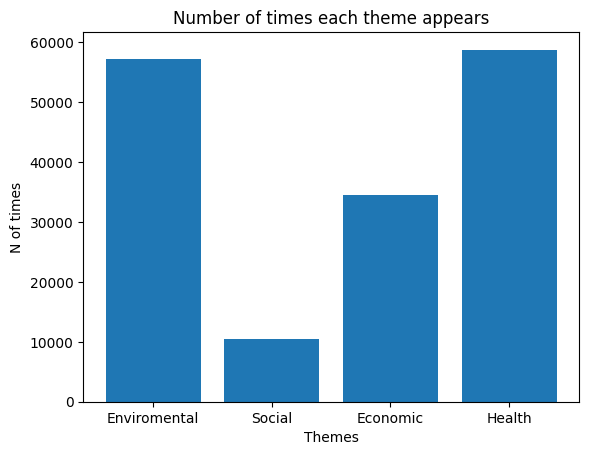

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# Read labels from labels text file in twenty
data = np.loadtxt('custumerreviewsvisual\labels.txt', delimiter=',')

# Extract all columns but not the first one
columns = data[:, 1:]

# Summation of each column to add up how often each theme appears
sum_themes = np.sum(columns, axis=0)

# TODO if non of the rows = 1 then make label 5 (no theme) =+

# Identify and sum any rows without 1s in each column by checking if the sum of the whole row is 0
rows_without_theme = np.sum(columns, axis=1) == 0

# Sum
num_rows_without_theme = np.sum(rows_without_theme)
print(num_rows_without_theme)

# Add new column represting no themes classified with 1 as no theme and 0 having a theme
data = np.column_stack((data, rows_without_theme.astype(int)))

# Create new labels text file with addition of the new "no themes" column as int
np.savetxt( 'new_lables.txt', data, delimiter=',', fmt='%d')


# Display the results
labels = ['Enviromental', 'Social', 'Economic', 'Health']
plt.bar(labels, sum_themes)
plt.xlabel('Themes')
plt.ylabel('N of times')
plt.title('Number of times each theme appears')
plt.show()